<a href="https://colab.research.google.com/github/jjyjung/ai_mfg/blob/main/%ED%9A%8C%EC%A0%84%EA%B8%B0%EA%B3%84_%EA%B3%A0%EC%9E%A5%EC%A7%84%EB%8B%A8_%EC%8B%A4%EC%8A%B5_ML%EC%B6%94%EA%B0%80_ver2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회전기계 고장진단 실습**

**제목:** 회전기계의 고장유형 분석을 위한 AI 데이터셋 가이드북  <br>
**Description:** 회전기계로부터 수집한 데이터를 전처리하고, 신경망 학습을 이용하여 회전기계의 정상/고장 여부 및 고장 유형을 판단하고자 함

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터 및 예제를 수정한 교육자료입니다.

https://www.kamp-ai.kr/front/dataset/AiDataDetail.jsp?AI_SEARCH=&page=1&DATASET_SEQ=18

## 0. 회전기계 (Rotor testbed)

> 산업 현장에서 사용되는 기계 구조물은 대부분 정상 상태로 가동되며, 수집되는 데이터 역시 정상 유형이 90% 이상을 차지한다. 고장유형의 경우 자연 발생적으로 취득되는 데이터가 매우 희박하고, 실제 구조물에 인위적인 고장을 가하여 데이터를 취득하는 방식은 비효율적이므로, 이는 데이터간 불균형 문제를 초래할 수 있다. Rotor testbed를 이용하면, 여러 고장유형에 대해 특징을 분석하고, 정상 및 고장유형을 분류할 수 있는 충분한 양의 고장 데이터를 수집할 수 있다. 많은 산업 현장(발전소 등)에서 주로 사용되는 회전 설비의 진동데이터를 수집하고, 고장을 분석 및 진단하는 학습 모델을 구축하여, 이후 기술 확장을 통해 발전소나, 대규모 공장의 자동화 라인 등에 활용을 목표로 한다.

![fig.01.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.01.png?raw=true&style=centerme)<br>

(1) Controller Module
- 본 rotor testbed의 Controller에서 수동 모드를 이용하여 Motor 회전속도가 약 1500 RPM인 경우, 진동 데이터를 구축하였다. <br>
<br>

(2) BLDC Motor
- 본 rotor testbed는 BLDC Motor는 Brush가 제거된 형태로 브러쉬를 통한 기계적인 접촉이 없는 DC Motor이다.
- BLDC Motor는 소음이 비교적 적으며, 출력을 세밀하게 조절할 수 있다는 장점이 있다.<br>
<br>

(3) Disks
![fig.02.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.02.png?raw=true)<br>
- 본 rotor testbed는 총 2개의 aluminum disk가 있다.
- 각각의 disk에는 회전 불균형을 구현할 수 있는 bolt 체결 홀이 있다.
- 축의 중심으로부터 bolt 체결 홀의 거리는 약 60mm이며, blot 체결 홀은 모두 36개이다.<br>
<br>

(4) Spec
- 본 rotor testbed의 사양은 다음과 같다.

|    구분    |                 사양                 |
|:----------:|:------------------------------------:|
| Size       | 673 mm (W) x 280 mm (D) x 281 mm (H) |
| Weight     |                 25kg                 |
| Material   |               Aluminum               |
| Bearing    |             6202ZZ x 2EA             |
| Motor      |  DC 12V x 0.25HP (0.2W), 0-3000 RPM  |
| Main power |                AC 220V               |

(5) 실험 환경
- 본 rotor testbed의 실험 환경은 다음과 같다.
- 회전 속도는 약 1500 RPM을 사용하였으며, 이 경우 기계의 최대 주파수는 25 Hz가 된다.
- Nyquist 이론에 의해 기계의 최대 주파수의 2배 이상으로 sampling rate을 설정해야하며, 측정값의 신호를 분석하기 위해서는 5-10배 정도의 sampling rate가 요구된다. 
- 본 실험의 RPM에 따른 적절한 sampling rate는 125-250 Hz 정도이며, 이번 실험에서는 1 kHz로 Z방향 진동 데이터(가속도)가 측정되었다.

| Rotor testbed |                   |
|:-------------:|:-----------------:|
| RPM           |     about 1500    |
| Sampling rate | 1 kHz (0.001 sec) |

※ 코드 실행 전에 다음과 같은 가상환경이 구축되어있는지 확인해주세요. 버전이 다른 경우 오류가 발생할 수 있습니다.<br>
Python 버전 : 3.7.3

In [ ]:
!python --version

Python 3.7.13


## 1. 라이브러리 / 데이터 불러오기

### 1-1. 라이브러리 불러오기

필요한 라이브러리를 불러온다.  <br>
오류가 발생할 경우, !pip install 패키지명을 입력하여 설치하도록 한다.

예) !pip install numpy

본 가이드북에서 필요한 패키지들은 모두 requirements.txt에 있다.

필요한 패키지 정보파일인 requirements.txt 을 현재 디렉토리에 업로드해보기

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

업로드한 requirements.txt 파일 확인하기

In [ ]:
pwd

'/content'

In [ ]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

### 1-2. 데이터 불러오기

pd.read_csv(“데이터파일_경로명”)을 통해 csv 형태의 데이터를 pandas의 DataFrame으로 읽어 들인다.  <br>

- 총 4개의 센서를 사용하므로 sensor1~sensor4로 명명하였다.  <br>
- 센서 데이터 취득 위치는 다음과 같다.<br>
<br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor1.png?raw=true"><br>[센서 설치 위치 (사진)]</center> <br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor2.png?raw=true"><br>[group 1]</center> <br>

<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/sensor3.png?raw=true"><br>[group 2]</center> <br>
<br>

- data는 데이터 취득 시간, 정상 유형(normal)과 고장유형 1-3 (type1, type2, type3)일 경우 센서 취득값으로 구성된다.  <br>
- 고장유형 1,2,3은 다음의 사진과 표를 확인하면 알 수 있다.<br>

![fault_type.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fault_type.png?raw=true)<br>

| 구분   | 특징                                                |
|--------|-----------------------------------------------------|
| Type 1 | Disk 2에 회전 불균형 (270도 위치에 볼트, 너트 부착) |
| Type 2 | Support 4에 지지 불균형                             |
| Type 3 | Type 1 + Type 2                                     |


In [ ]:
# group 1의 데이터를 사용할 경우, 아래 코드를 실행합니다.
sensor1 = pd.read_csv('/content/rotor/g1_sensor1.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor2 = pd.read_csv('/content/rotor/g1_sensor2.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor3 = pd.read_csv('/content/rotor/g1_sensor3.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
sensor4 = pd.read_csv('/content/rotor/g1_sensor4.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])

# # group 2의 데이터를 사용할 경우, 주석을 제거하고 아래 코드를 실행합니다.
# sensor1 = pd.read_csv('/content/rotor/g2_sensor1.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
# sensor2 = pd.read_csv('/content/rotor/g2_sensor2.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
# sensor3 = pd.read_csv('/content/rotor/g2_sensor3.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])
# sensor4 = pd.read_csv('/content/rotor/g2_sensor4.csv', names = ['time', 'normal', 'type1', 'type2', 'type3'])

### 1-3. 데이터 확인
불러온 데이터프레임의 변수 이름(normal_)을 입력하면 해당 내용을 확인해 볼 수 있다.

In [ ]:
sensor1

,time,normal,type1,type2,type3
0,0.000000,-0.853307,-3.464579,0.555219,3.919664
1,0.000736,-0.740463,-2.448986,-0.234687,4.145351
2,0.001472,-0.138630,-1.922383,-0.009000,2.941685
3,0.002208,0.049443,-0.906790,-0.272301,2.603155
4,0.002944,-0.289088,-0.568259,-0.986978,1.361874
...,...,...,...,...,...
190213,139.996768,-1.156354,-2.696750,0.844491,-2.109427
190214,139.997504,-0.930666,-1.380241,0.919720,-2.222270
190215,139.998240,-0.554521,-2.132532,0.731647,-2.109427
190216,139.998976,-1.419655,-2.433448,1.183022,-3.087405


In [ ]:
sensor1['time']

0           0.000000
1           0.000736
2           0.001472
3           0.002208
4           0.002944
             ...    
190213    139.996768
190214    139.997504
190215    139.998240
190216    139.998976
190217    139.999712
Name: time, Length: 190218, dtype: float64

데이터는 140초 간의 시간을 포함하여 총 5개의 컬럼으로 이루어져 있다. <br>

In [ ]:
print('sensor 1의 데이터 크기', sensor1.shape)
print('sensor 2의 데이터 크기', sensor2.shape)
print('sensor 3의 데이터 크기', sensor3.shape)
print('sensor 4의 데이터 크기', sensor4.shape)

sensor 1의 데이터 크기 (190218, 5)
sensor 2의 데이터 크기 (184211, 5)
sensor 3의 데이터 크기 (196079, 5)
sensor 4의 데이터 크기 (183969, 5)


그러나 데이터를 확인하면 센서마다 데이터를 취득하는 sampling rate이 다르기 때문에, 데이터의 사이즈가 다른 것을 확인할 수 있다. <br>
따라서 본 가이드북에서는 동일한 time interval의 데이터를 취득하기 위해 데이터를 0.001 sec 간격으로 선형보간하였다.

### 1-4. 데이터 보간
#### 데이터 선형보간

각 센서별 sampling rate은 다음과 같다. <br>

| Sensor 1 | Sensor 2 | Sensor 3 | Sensor 4 |
|:--------:|:--------:|----------|----------|
| 0.000736 | 0.000760 | 0.000714 | 0.000761 |

계측된 센서 데이터의 계측 시간 간격 (sampling rate)이 일정하지 않은 경우, 데이터 간 정확한 비교가 어려우므로 계측 시간의 동일화를 위해 전처리(선형 보간)가 요구된다. 선형보간의 방법은 아래 그림과 같다.
<br>
![interpolation.png](https://github.com/jjyjung/ai_mfg/blob/main/img/interpolation.png?raw=true)<br>
<br>
따라서 표에 나온 sampling rate을 이용하여 각 센서의 데이터를 0.001 sec 간격으로 선형보간 한다 (총 140초). <br>
 - interpolate.interp1d() : [선형보간 함수](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)를 이용하였다.

In [ ]:
from scipy import interpolate

x_new = np.arange(0, 140, 0.001)

y_new1 = []; y_new2 = []; y_new3 = []; y_new4 = []
for item in ['normal', 'type1', 'type2', 'type3']:
    f_linear1 = interpolate.interp1d(sensor1['time'], sensor1[item], kind='linear'); y_new1.append(f_linear1(x_new))
    f_linear2 = interpolate.interp1d(sensor2['time'], sensor2[item], kind='linear'); y_new2.append(f_linear2(x_new))
    f_linear3 = interpolate.interp1d(sensor3['time'], sensor3[item], kind='linear'); y_new3.append(f_linear3(x_new))
    f_linear4 = interpolate.interp1d(sensor4['time'], sensor4[item], kind='linear'); y_new4.append(f_linear4(x_new))
    
sensor1 = pd.DataFrame(np.array(y_new1).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor2 = pd.DataFrame(np.array(y_new2).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor3 = pd.DataFrame(np.array(y_new3).T, columns = ['normal', 'type1', 'type2', 'type3'])
sensor4 = pd.DataFrame(np.array(y_new4).T, columns = ['normal', 'type1', 'type2', 'type3'])

In [ ]:
sensor1

,normal,type1,type2,type3
0,-0.853307,-3.464579,0.555219,3.919664
1,-0.524588,-2.260096,-0.153734,3.713601
2,-0.003708,-1.193805,-0.197890,2.698827
3,-0.297674,-0.490986,-0.972668,1.338978
4,-0.091203,0.790771,-0.913384,0.701167
...,...,...,...,...
139995,-1.057411,-1.389236,0.664186,-1.498190
139996,-0.513635,-1.368793,1.050553,-0.982626
139997,-1.085213,-2.281763,0.868204,-2.144997
139998,-0.677177,-1.887220,0.792975,-2.146224


선형 보간 작업을 위해 데이터를 센서별로 묶어두었지만, 실제 취득된 형태로 데이터를 다시 조정한다.

In [ ]:
normal_ = pd.concat([sensor1['normal'],sensor2['normal'],sensor3['normal'],sensor4['normal']],axis=1)
type1_  = pd.concat([sensor1['type1'], sensor2['type1'], sensor3['type1'], sensor4['type1']], axis=1)
type2_  = pd.concat([sensor1['type2'], sensor2['type2'], sensor3['type2'], sensor4['type2']], axis=1)
type3_  = pd.concat([sensor1['type3'], sensor2['type3'], sensor3['type3'], sensor4['type3']], axis=1)

normal_.columns = ['s1', 's2', 's3', 's4']; type1_.columns = ['s1', 's2', 's3', 's4']
type2_.columns  = ['s1', 's2', 's3', 's4']; type3_.columns = ['s1', 's2', 's3', 's4']

In [ ]:
normal_

,s1,s2,s3,s4
0,-0.853307,0.048823,-0.437626,-1.116226
1,-0.524588,-0.029477,-0.149817,-0.659694
2,-0.003708,-0.004751,0.280889,-0.857345
3,-0.297674,0.009673,-0.303281,-0.685318
4,-0.091203,0.096215,-0.320263,-0.303108
...,...,...,...,...
139995,-1.057411,0.587429,0.275044,0.289837
139996,-0.513635,-0.137874,-0.045973,0.131462
139997,-1.085213,0.002242,-0.164593,-0.087380
139998,-0.677177,-0.308897,0.288252,1.319862


In [ ]:
print('normal 상태 데이터의 사이즈', normal_.shape)
print('type1  상태 데이터의 사이즈', type1_.shape)
print('type2  상태 데이터의 사이즈', type2_.shape)
print('type3  상태 데이터의 사이즈', type3_.shape)

normal 상태 데이터의 사이즈 (140000, 4)
type1  상태 데이터의 사이즈 (140000, 4)
type2  상태 데이터의 사이즈 (140000, 4)
type3  상태 데이터의 사이즈 (140000, 4)


### 1-5. 데이터 분석
#### 데이터 시각화
특정 시간에서의 시계열 샘플을 플롯

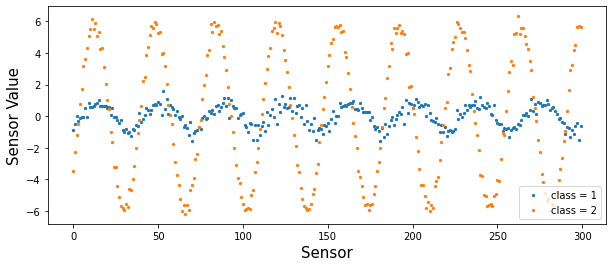

In [ ]:
# python 버전 : 3.7.3 (버전에 따라, jupyter notebook에서 아래 코드가 실행되지 않을 수 있습니다)
# 실행이 되지 않는 경우, 아래 코드는 주석처리하고 넘어가도 학습에 영향을 주지 않습니다 (데이터 확인용)

plt.figure(figsize = (10, 4))
plt.scatter(range(0,300), normal_['s1'][:300], label="class = " + str(1), marker='o', s=5)
plt.scatter(range(0,300), type1_['s1'][:300], label="class = " + str(2), marker='o', s=5)
    
plt.legend(loc="lower right")
plt.xlabel("Sensor", fontsize=15)
plt.ylabel("Sensor Value", fontsize=15)
plt.show()
plt.close()

#### 데이터 상관분석
df.corr()을 입력하면 센서 별 상관관계를 확인할 수 있다.

In [ ]:
normal_.corr()

,s1,s2,s3,s4
s1,1.000000,-0.007093,0.004297,-0.003377
s2,-0.007093,1.000000,-0.002992,0.111121
s3,0.004297,-0.002992,1.000000,-0.006434
s4,-0.003377,0.111121,-0.006434,1.000000


Correlation Matrix(상관 행렬)를 통해 센서값 별 상관관계를 이미지로 확인할 수 있다.

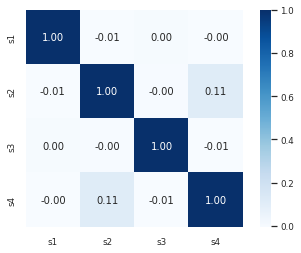

In [ ]:
# python 버전 : 3.7.3 (버전에 따라, jupyter notebook에서 아래 코드가 실행되지 않을 수 있습니다)
# 실행이 되지 않는 경우, 아래 코드는 주석처리하고 넘어가도 학습에 영향을 주지 않습니다 (데이터 확인용)

names = ['s1','s2','s3','s4']
cm = np.corrcoef(normal_[names].values.T)
sns.set(font_scale=0.8)
sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=names, xticklabels=names, cmap=plt.cm.Blues)

절대값이 0.6보다 클수록 강한 상관관계를 가지며, 0.3보다 작을수록 약한 상관관계를 갖는다. <br>
양수의 경우 정(+)의 상관관계, 음수의 경우 부(-)의 상관관계를 갖는다.

## 2. 데이터 전처리

### 2-1. 데이터 필터링 (Filtering)

센서로부터 취득한 데이터는 기본적으로 기계학습에 좋지 않은 영향을 주는 노이즈(Noise)가 포함되어 있다. 센서 데이터에 평균을 취하면 데이터의 노이즈를 제거할 수 있는데, 측정하려는 물리량이 시간에따라 변하는 경우에는 적절하지 않다(데이터의 동적인 변화를 모두 smoothing하는 결과). 따라서 데이터에서 노이즈를 제거하면서, 동적인 변화를 반영하는 방법으로 이동평균필터가 있으며, 본 가이드북에서는 데이터의 노이즈를 처리하기 위해 이동평균필터(Moving Average filter)를 사용하였다. 

- 이동평균필터 (Moving Average filter)는 python에서 [np.convolve()](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) 함수로 구현된다 (MATLAB의 filter 함수와 동일). <br>
    - np.convolve() : 1차원 신호를 입력으로 받아, 최근 M개의 측정값들의 평균을 구한다.
    
    - 모든 데이터의 평균이 아니라, 정해진 크기(M개)의 최근 측정값들로만 평균을 구한다. <br>
    - 일반적으로 신호 데이터의 변동이 빠른 경우에는 M값을 작게하고, 신호 데이터의 변동이 느린 경우에는 M값을 크게한다. <br>
    - 자세한 이론은 [자료](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)를 참고하면 좋다.

In [ ]:
M = 15

normal_s1 = np.convolve(normal_['s1'], np.ones(M), 'valid') / M; normal_s1 = normal_s1.reshape(len(normal_s1),1)
normal_s2 = np.convolve(normal_['s2'], np.ones(M), 'valid') / M; normal_s2 = normal_s2.reshape(len(normal_s2),1)
normal_s3 = np.convolve(normal_['s3'], np.ones(M), 'valid') / M; normal_s3 = normal_s3.reshape(len(normal_s3),1)
normal_s4 = np.convolve(normal_['s4'], np.ones(M), 'valid') / M; normal_s4 = normal_s4.reshape(len(normal_s4),1)

type1_s1 = np.convolve(type1_['s1'], np.ones(M), 'valid') / M; type1_s1 = type1_s1.reshape(len(type1_s1),1)
type1_s2 = np.convolve(type1_['s2'], np.ones(M), 'valid') / M; type1_s2 = type1_s2.reshape(len(type1_s2),1)
type1_s3 = np.convolve(type1_['s3'], np.ones(M), 'valid') / M; type1_s3 = type1_s3.reshape(len(type1_s3),1)
type1_s4 = np.convolve(type1_['s4'], np.ones(M), 'valid') / M; type1_s4 = type1_s4.reshape(len(type1_s4),1)

type2_s1 = np.convolve(type2_['s1'], np.ones(M), 'valid') / M; type2_s1 = type2_s1.reshape(len(type2_s1),1)
type2_s2 = np.convolve(type2_['s2'], np.ones(M), 'valid') / M; type2_s2 = type2_s2.reshape(len(type2_s2),1)
type2_s3 = np.convolve(type2_['s3'], np.ones(M), 'valid') / M; type2_s3 = type2_s3.reshape(len(type2_s3),1)
type2_s4 = np.convolve(type2_['s4'], np.ones(M), 'valid') / M; type2_s4 = type2_s4.reshape(len(type2_s4),1)

type3_s1 = np.convolve(type3_['s1'], np.ones(M), 'valid') / M; type3_s1 = type3_s1.reshape(len(type3_s1),1)
type3_s2 = np.convolve(type3_['s2'], np.ones(M), 'valid') / M; type3_s2 = type3_s2.reshape(len(type3_s2),1)
type3_s3 = np.convolve(type3_['s3'], np.ones(M), 'valid') / M; type3_s3 = type3_s3.reshape(len(type3_s3),1)
type3_s4 = np.convolve(type3_['s4'], np.ones(M), 'valid') / M; type3_s4 = type3_s4.reshape(len(type3_s4),1)

In [ ]:
normal_temp = np.concatenate((normal_s1,normal_s2,normal_s3,normal_s4), axis = 1)
type1_temp = np.concatenate((type1_s1,type1_s2,type1_s3,type1_s4), axis = 1)
type2_temp = np.concatenate((type2_s1,type2_s2,type2_s3,type2_s4), axis = 1)
type3_temp = np.concatenate((type3_s1,type3_s2,type3_s3,type3_s4), axis = 1)

In [ ]:
normal_temp.shape

(139986, 4)

### 2-2. 데이터 정규화

데이터 (140,000,4)의 센서 값들이 다양한 Range를 갖는다. <br>
이는 신경망 학습에 그대로 이용하기엔 적절하지 않다. <br>
일반적으로 인풋 값들을 정규화(Normalization)하는데, 본 가이드북에서는 Min-max normalization 활용하여 진행하였다. <br>
Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling한다.

1) Normal data의 최대값(max)과 최소값(min)을 구한다. <br>
2) 정규화할 데이터 값(x)과 앞서 구한 최대값(Xmax), 최소값(Xmin)을 다음의 식에 대입한다.<br>
<center><img src = "https://github.com/jjyjung/ai_mfg/blob/main/img/minmax.png?raw=true"></center>

3) 이와 같은 식은 sklearn.preprocessing의 MinMaxScaler에 구현되어있다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(normal_)
normal = scaler.transform(normal_temp)
type1  = scaler.transform(type1_temp)
type2  = scaler.transform(type2_temp)
type3  = scaler.transform(type3_temp)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


1) MinMaxScaler.fit을 통해 normal data의 min, max를 구한다. <br>
2) MinMaxScaler.transform를 통해 각 데이터를 normal data의 min, max 값으로 정규화한다.

데이터 확인

In [ ]:
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[0.57598822 0.50553898 0.56439491 0.44551164]
 [0.60960317 0.50513674 0.58169332 0.44848001]
 [0.62990663 0.5047345  0.59547186 0.46260474]
 ...
 [0.51874981 0.50106998 0.60999194 0.50715712]
 [0.49713039 0.51588928 0.6074125  0.53093987]
 [0.45708747 0.52025039 0.60349765 0.53976513]]
------------------------------------------------
normal data size =  (139986, 4)


이동평균 필터링 후에 데이터의 사이즈를 조정한다(옵션, 본 가이드 북에서는 숫자를 쉽게 확인할 수 있도록 함). <br>
rotor testbed 가동 후 몇 초간 (약 30초)의 데이터를 탈락시키고 이후 데이터를 사용하였다(steady state). <br>

데이터 사이즈를 (100000, 4)로 맞춰주었다.

In [ ]:
normal = normal[30000:130000][:]
type1  = type1[30000:130000][:]
type2  = type2[30000:130000][:]
type3  = type3[30000:130000][:]

In [ ]:
print(normal)
print('------------------------------------------------')
print('normal data size = ', normal.shape)

[[0.42588581 0.56360116 0.59076635 0.45259554]
 [0.39980512 0.54859132 0.57699856 0.4486034 ]
 [0.38031149 0.54190146 0.57998374 0.44726771]
 ...
 [0.48028648 0.53048363 0.62114742 0.51024851]
 [0.44818273 0.53444251 0.62103995 0.49126006]
 [0.42832757 0.5501298  0.60917718 0.47827626]]
------------------------------------------------
normal data size =  (100000, 4)


### 2-3. 데이터 분할

Normal, type1-3 abnormal data를 1:1:1:1의 비율로 각각 training data, validation data, test data로 나눈다. <br>
이 때, 학습 : 검증 : 테스트 = 6 : 2 : 2 이다.

In [ ]:
# 데이터 분배
normal_train = normal[:][:60000]; normal_valid = normal[:][60000:80000]; normal_test = normal[:][80000:]
type1_train  = type1[:][:60000];  type1_valid  = type1[:][60000:80000];  type1_test  = type1[:][80000:]
type2_train  = type2[:][:60000];  type2_valid  = type2[:][60000:80000];  type2_test  = type2[:][80000:]
type3_train  = type3[:][:60000];  type3_valid  = type3[:][60000:80000];  type3_test  = type3[:][80000:]

### 2-4. ML모델 학습을 위한 통계지표 추출

머신러닝 알고리즘(SVM, RandomForest) 학습을 위하여 시계열 데이터에서 통계지표를 추출한다. <br>
본 실험에서는 0.5초동안의 데이터를 하나의 구간으로 보고, 해당 구간에서 통계지표를 추출한다. <br>
평균, 표준편차, 왜도, 첨도 등 아래 표와 같이 10가지 통계지표를 사용한다.


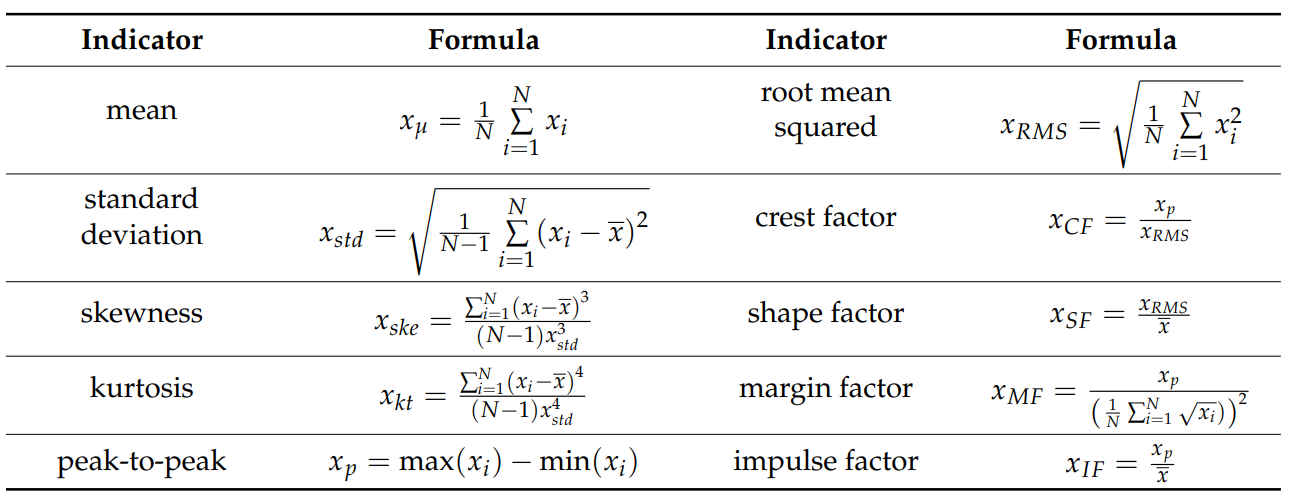

In [ ]:
#SI Functions
def get_mean(x):
    avg = np.mean(x)
    return(avg)

def get_std(x):
    std = np.std(x)
    return(std)

def get_skewness(x):
    skewness = sum((x - np.mean(x))**3) / ((len(x)-1)*(np.std(x)**3))
    return(skewness)

def get_kurtosis(x):
    kurtosis = sum((x - np.mean(x))**4) / ((len(x)-1)*(np.std(x)**4))
    return (kurtosis)

def get_p2p(x):
    p2p = (np.max(x) - np.min(x))
    return(p2p)

def get_rms(x):
    rms = np.sqrt(sum(x**2) / len(x))
    return(rms)

def get_crestFactor(x):
    crestFactor = get_p2p(x) / get_rms(x)
    return(crestFactor)

def get_shapeFactor(x):
    shapeFactor = get_rms(x) / get_mean(x)
    return(shapeFactor)
    
def get_marginFactor(x):
    marginFactor = np.max(x) / (np.mean((np.sqrt(abs(x))))**2)
    return(marginFactor)

def get_impulseFactor(x):
    impulseFactor = np.max(x) / np.mean(abs(x))
    return(impulseFactor)

def make_df(x, sensor_num):
    mean_value = np.apply_along_axis(get_mean, 1, x)
    std_value = np.apply_along_axis(get_std, 1, x)
    skewness_value = np.apply_along_axis(get_skewness, 1, x)
    kurtosis_value = np.apply_along_axis(get_kurtosis, 1, x)
    p2p_value = np.apply_along_axis(get_p2p, 1, x)
    rms_value = np.apply_along_axis(get_rms, 1, x)
    crestFactor_value = np.apply_along_axis(get_crestFactor, 1, x)
    shapeFactor_value = np.apply_along_axis(get_shapeFactor, 1, x)
    marginFactor_value = np.apply_along_axis(get_marginFactor, 1, x)
    impulseFactor_value = np.apply_along_axis(get_impulseFactor, 1, x)
    
    df = pd.DataFrame({'mean_'+sensor_num:mean_value, 'std_'+sensor_num:std_value, 'skewness_'+sensor_num:skewness_value, 
                       'kurtosis_'+sensor_num:kurtosis_value, 'p2p_'+sensor_num:p2p_value, 'rms_'+sensor_num:rms_value,
                       'crest_'+sensor_num:crestFactor_value, 'shape_'+sensor_num:shapeFactor_value, 
                       'margin_'+sensor_num:marginFactor_value, 'impulse_'+sensor_num:impulseFactor_value})
    
    return(df)

In [ ]:
def generate_data(data):
  data = pd.DataFrame(data)
  df = pd.DataFrame()
  i = 0
  window_len = 500
  while data.shape[0] >= window_len:
    input = data.iloc[window_len*i:window_len*(i+1),:]
    input_arr = np.array(input).reshape((1,-1))
    df = pd.concat([df, pd.DataFrame(input_arr)], axis=0)
    # print(df)
    data = data.iloc[window_len*(i+1):,:]
    # i += 1

  df = df.reset_index(drop=True)
  return df.drop(index=df.index[-1])


def extract_SI(data):
  s1_tmp = generate_data(data[:,0])
  s2_tmp = generate_data(data[:,1])
  s3_tmp = generate_data(data[:,2])
  s4_tmp = generate_data(data[:,3])

  s1_ext = make_df(s1_tmp, 's1')
  s2_ext = make_df(s2_tmp, 's2')
  s3_ext = make_df(s3_tmp, 's3')
  s4_ext = make_df(s4_tmp, 's4')

  df = pd.concat([s1_ext, s2_ext, s3_ext, s4_ext], axis=1)
  return df

In [ ]:
## ML용 전처리
normal_train_ext = extract_SI(normal_train)
type1_train_ext = extract_SI(type1_train)
type2_train_ext = extract_SI(type2_train)
type3_train_ext = extract_SI(type3_train)

normal_test_ext = extract_SI(normal_test)
type1_test_ext = extract_SI(type1_test)
type2_test_ext = extract_SI(type2_test)
type3_test_ext = extract_SI(type3_test)

In [ ]:
# 레이블링
normal_train_ext_labeled = np.append(normal_train_ext, np.repeat(0, normal_train_ext.shape[0]).reshape(normal_train_ext.shape[0], 1), axis=1)
type1_train_ext_labeled = np.append(type1_train_ext, np.repeat(1, type1_train_ext.shape[0]).reshape(type1_train_ext.shape[0], 1), axis=1)
type2_train_ext_labeled = np.append(type2_train_ext, np.repeat(2, type2_train_ext.shape[0]).reshape(type2_train_ext.shape[0], 1), axis=1)
type3_train_ext_labeled = np.append(type3_train_ext, np.repeat(3, type3_train_ext.shape[0]).reshape(type3_train_ext.shape[0], 1), axis=1)

normal_test_ext_labeled = np.append(normal_test_ext, np.repeat(0, normal_test_ext.shape[0]).reshape(normal_test_ext.shape[0], 1), axis=1)
type1_test_ext_labeled = np.append(type1_test_ext, np.repeat(1, type1_test_ext.shape[0]).reshape(type1_test_ext.shape[0], 1), axis=1)
type2_test_ext_labeled = np.append(type2_test_ext, np.repeat(2, type2_test_ext.shape[0]).reshape(type2_test_ext.shape[0], 1), axis=1)
type3_test_ext_labeled = np.append(type3_test_ext, np.repeat(3, type3_test_ext.shape[0]).reshape(type3_test_ext.shape[0], 1), axis=1)


print(normal_train_ext_labeled.shape)
print(type1_train_ext_labeled.shape)
print(type2_train_ext_labeled.shape)
print(type3_train_ext_labeled.shape)

(119, 41)
(119, 41)
(119, 41)
(119, 41)


In [ ]:
combined_trn = np.concatenate((normal_train_ext_labeled, type1_train_ext_labeled, type2_train_ext_labeled, type3_train_ext_labeled))
combined_test = np.concatenate((normal_test_ext_labeled, type1_test_ext_labeled, type2_test_ext_labeled, type3_test_ext_labeled))

np.random.shuffle(combined_trn)
np.random.shuffle(combined_test)

### 2-5. DL모델 학습을 위한 전처리

#### 데이터 라벨 부여 및 뒤섞기
Normal data = 0 <br>
Type1  data = 1 <br>
Type2  data = 2 <br>
Type3  data = 3 <br>
학습을 위해 각 데이터에 라벨을 부여하고, 학습을 위해 뒤섞는다. <br>
- train data는 train epoch마다 랜덤한 순서로 학습하기 위해 dataloader를 이용하여 shuffle<br>
- valid data와 test data는 실행할 때 고정된 임의의 순서로 가져오기 위해 shuffle 함수 사용<br>

In [ ]:
## DL용 전처리
train = np.concatenate((normal_train, type1_train, type2_train,type3_train))
valid = np.concatenate((normal_valid, type1_valid, type2_valid,type3_valid))
test = np.concatenate((normal_test, type1_test, type2_test,type3_test))

In [ ]:
print("train data의 형태:", train.shape)
print("valid data의 형태:", valid.shape)
print(" test data의 형태:", test.shape)

train data의 형태: (240000, 4)
valid data의 형태: (80000, 4)
 test data의 형태: (80000, 4)


In [ ]:
train_label = np.concatenate((np.full((60000,1),0),np.full((60000,1),1),np.full((60000,1),2),np.full((60000,1),3)))
valid_label = np.concatenate((np.full((20000,1),0),np.full((20000,1),1),np.full((20000,1),2),np.full((20000,1),3)))
test_label = np.concatenate((np.full((20000,1),0),np.full((20000,1),1),np.full((20000,1),2),np.full((20000,1),3)))

In [ ]:
idx = np.arange(train.shape[0]); np.random.shuffle(idx); train = train[:][idx]; 
train_label = train_label[:][idx]

idx_v = np.arange(valid.shape[0]); np.random.shuffle(idx_v); valid = valid[:][idx_v]; 
valid_label = valid_label[:][idx_v]

idx_t = np.arange(test.shape[0]); np.random.shuffle(idx_t); test = test[:][idx_t];
test_label = test_label[:][idx_t]

In [ ]:
x_train = torch.from_numpy(train).float()
y_train = torch.from_numpy(train_label).float().T[0]

x_valid = torch.from_numpy(valid).float()
y_valid = torch.from_numpy(valid_label).float().T[0]

x_test = torch.from_numpy(test).float()
y_test = torch.from_numpy(test_label).float().T[0]

In [ ]:
print("변경 전")
train

변경 전


array([[0.70944402, 0.44957032, 0.56872531, 0.44777718],
       [0.33148699, 0.30159861, 0.611086  , 0.53559587],
       [0.55320032, 0.41149385, 0.62221044, 0.56834448],
       ...,
       [0.09661623, 0.30229725, 0.60443049, 0.56577576],
       [0.48519721, 0.49135805, 0.56410023, 0.57092183],
       [0.41325678, 0.47408739, 0.58478979, 0.53363183]])

In [ ]:
print("변경 후")
x_train

변경 후


tensor([[0.7094, 0.4496, 0.5687, 0.4478],
        [0.3315, 0.3016, 0.6111, 0.5356],
        [0.5532, 0.4115, 0.6222, 0.5683],
        ...,
        [0.0966, 0.3023, 0.6044, 0.5658],
        [0.4852, 0.4914, 0.5641, 0.5709],
        [0.4133, 0.4741, 0.5848, 0.5336]])

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train, batch_size = 5000, shuffle=True)

valid = TensorDataset(x_valid, y_valid)
valid_dataloader = DataLoader(valid, batch_size = len(x_valid), shuffle=False)

test = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test, batch_size = len(x_valid), shuffle=False)

## 3. 모델 구축



###3-1. 서포트벡터머신 (SVM)
...

### 3-2. 랜덤 포레스트 (Random Forest)
...

### 3-3. 심층신경망 (DNN)

심층신경망 (DNN)은 인공신경망에서 모델 내 은닉층을 많이 늘려서 학습의 결과를 향상시키는 방법이다. <br>
라벨이 있는 데이터이므로, supervised learning을 통해 classification을 위한 학습 모델을 구축한다.

pytorch의 network는 class 형태로 구성된다.
자세한 내용은 pytorch 공식 사이트에서 확인 가능하다(링크 포함).

1. ```KAMP_DNN을 구현하는 class는 nn.Module class를 상속한다.```
2. ```__init__에서는 신경망 layer를 초기화한다.```
   -   nn.Linear() : [선형계층](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)으로 weight와 bias을 사용하여 입력에 선형 변환을 적용하는 모듈
       - in_features  : 신경망으로 입력되는 size
       - out_features : 신경망에서 출력되는 size <br>
       <br>
   -   nn.Relu() : [ReLu 활성화함수 계층](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)으로 비선형 활성화를 통해 모델의 입력과 출력 사이에 복잡한 관계(mapping)를 만든다. <br>
       비선형 활성화는 nn.Linear로 이루어진 선형계층에 비선형성을 도입하여 신경망이 보다 복잡한 현상을 학습할 수 있도록 돕는다.<br>
       <br>
   -   nn.Dropout() : [드롭아웃 계층](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)으로 신경망의 일부를 의도적으로 학습에서 제외함으로써 모델을 일반화하는 역할을 한다(과적합 방지). <br>
       ![fig.03.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.03.png?raw=true)<br>
        <br>
   -   input_size = 4 : 계측되는 sensor 값들 4개
   -   ouput_size = 4 : 정상 + 고장유형 개수 4개
   -   hidden_size는 본 가이드 북에서는 100으로 하였으나, parameter study를 통해 조절
   -   layer의 개수는 데이터에 따라 조절 (여기서는 2~4개의 layer 사용) <br>
   <br>
3. ```forward 에서는 초기화된 레이어에 입력 데이터를 전달하고 최종 출력을 얻는다.```

In [ ]:
# layer를 더 늘리고 싶은 경우 주석을 제거하고 사용합니다.

class KAMP_DNN(nn.Module):
    def __init__(self):
        super(KAMP_DNN, self).__init__()
        self.layer1   = nn.Linear(in_features = 4, out_features = 100)
        self.layer2   = nn.Linear(in_features = 100, out_features = 100)
        self.layer3   = nn.Linear(in_features = 100, out_features = 100)
        self.layer4   = nn.Linear(in_features = 100, out_features = 4)
        
        self.dropout  = nn.Dropout(0.2)
        self.relu     = nn.ReLU()

    def forward(self, input):
        out = self.layer1(input)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.layer2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.layer3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.layer4(out)
        return out
    
model_check = KAMP_DNN()
print(model_check)

KAMP_DNN(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)


### 3-4. 합성곱신경망 (CNN)
합성곱신경망 (CNN)은 인공신경망의 한 종류이며, 주로 Matrix 데이터나 이미지 데이터에 대하여 특징을 추출하는데에 쓰인다. <br>
라벨이 있는 데이터 이므로, supervised learning을 통해 classification을 위한 학습 모델을 구축한다. <br>

pytorch의 network는 class 형태로 구성된다. 자세한 내용은 pytorch 공식 사이트에서 확인 가능하다(링크 포함).

1. ```KAMP_CNN을 구현하는 class는 nn.Module class를 상속한다.```
2. ```__init__에서는 신경망 layer를 초기화한다.```
   -   nn.Sequential() : 계층이 순차적으로 실행되도록 담는 [sequential container](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)로서 연산순서를 원하는데로 다음 계층으로 전달할 수 있다. <br>
   <br>
   -   nn.Conv1d() : [1차원 합성곱 계층](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)으로서 주로 자연어와 같은 시계열 데이터에 많이 사용된다.
       - 이미지처리에서 주로 사용되는 2차원 합성곱 계층은 filter가 가로와 세로로 이동하면서 연산된다.
       - 반면 1차원 합성곱 계층의 연산은 filter가 가로로만 이동하면서 output을 계산한다. <br>
       ![fig.04.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.04.png?raw=true)<br>
       <br>
       - input shape : torch.nn.conv1d의 입력 사이즈는 [Batch size, Input channel size, sequence length]이다. <br>
           데이터를 학습하는 방식에 따라 입력 사이즈를 조절할 수 있으며, 본 가이드 북의 입력 사이즈는 다음과 같다. <br>
           [Batch size = 80000, Input channel size = 1, sequence length = 4]
            ![fig.05.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.05.png?raw=true)<br>
       <br>
       - in_channels : 신경망으로 입력되는 데이터의 channel size (컬러 이미지의 경우 첫 계층에서 RGB = 3을 사용)<br>
       - out_channels : 신경망에서 출력되는 데이터의 channel size (본 가이드북에서는 100을 사용하였으나 parameter study로 조절)<br>
       - kernel_size : 특징을 추출하는 filter의 size<br>
       - stride : kernel(filter)이 적용될 때, 이동하는 step size (2 이상인 경우, 데이터 size가 줄어든다)<br>
       - padding : 데이터 가장자리에 0을 채워 넣는 역할 (default는 valid)<br>
           {'vaild' : padding 안함, 'same' : 입력과 출력 size가 동일하도록 zero-padding, 혹은 다른 값}<br>
       - bias : bias term의 사용 여부 (default는 True)<br>
       <br>
   -   nn.BatchNorm1d() : [Batch 차원에서의 정규화 계층](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)으로 학습의 안정화에 기여한다.<br>
       <br>
   -   nn.Relu() : [ReLu 활성화함수 계층](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)으로 비선형 활성화를 통해 모델의 입력과 출력 사이에 복잡한 관계(mapping)를 만든다. <br>
       비선형 활성화는 nn.Linear로 이루어진 선형계층에 비선형성을 도입하여 신경망이 보다 복잡한 현상을 학습할 수 있도록 돕는다.<br>
       <br>
   -   nn.MaxPool1d() : [subsampling 계층](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html)으로 데이터의 특징을 보존하면서 크기를 줄여주는 역할을 한다 (과적합 방지에 사용).<br>
       평균적인 정보를 담는 average pooling과 가장 큰 정보를 담는 max pooling이 있다.
       nn.Conv1d() 계층의 stride와 비슷한 역할을 하지만, 모든 정보를 가진 상태로 정보를 희석한다는 특징을 갖는다.
   <br>
   -   nn.Dropout() : [드롭아웃 계층](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)으로 신경망의 일부를 의도적으로 학습에서 제외함으로써 모델을 일반화하는 역할을 한다(과적합 방지).<br>
   <br>
   -   layer의 개수는 데이터에 따라 조절 (여기서는 2~4개의 layer 사용) <br>
   <br>
3. ```forward 에서는 초기화된 레이어에 입력 데이터를 전달하고 최종 출력을 얻는다.```

In [ ]:
# layer를 더 늘리고 싶은 경우 주석을 제거하고 사용합니다.

class KAMP_CNN(nn.Module):
    def __init__(self):
        super(KAMP_CNN, self).__init__()
        self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=100, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1),
        nn.Dropout(p=0.2))
        
#         self.conv2 = nn.Sequential(
#         nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
#         nn.BatchNorm1d(100),
#         nn.ReLU(),
#         nn.MaxPool1d(kernel_size=1, stride=1),
#         nn.Dropout(p=0.2))
        
#         self.conv3 = nn.Sequential(
#         nn.Conv1d(in_channels=100, out_channels=100, kernel_size=2, stride=1, padding='same'),
#         nn.BatchNorm1d(100),
#         nn.ReLU(),
#         nn.MaxPool1d(kernel_size=1, stride=1),
#         nn.Dropout(p=0.2))
        
        self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=4, kernel_size=2, stride=1, padding='same'),
        nn.BatchNorm1d(4),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=1, stride=1))
        
        self.final_pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(4, 4)

    def forward(self, input):
        # 초기 input shape은 [80000, 4]이므로 input의 2번째 열(python에서는 1로 나타냄)에 채널 축을 확장 시킨다.
        input = input.unsqueeze(1)
        out = self.conv1(input)
#         out = self.conv2(out)
#         out = self.conv3(out)
        out = self.conv4(out)
        out = self.final_pool(out)
        out = self.linear(out.squeeze(-1))
        return out

model_check = KAMP_CNN()
print(model_check)

KAMP_CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 100, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv1d(100, 4, kernel_size=(2,), stride=(1,), padding=same)
    (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (final_pool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=4, out_features=4, bias=True)
)


아래의 그림은 본 가이드 북에서 사용한 kernel과 stride size가 어떻게 작용하는지 시각적으로 확인하기 위한 예시를 나타내었다.
![fig.06.png](https://github.com/jjyjung/ai_mfg/blob/main/img/fig.06.png?raw=true)<br>

다음의 코드로 확인 가능하다 (out_channels = 4).

In [ ]:
print('--------------------------------------------------------------------')
input = torch.tensor([[[0.0, 6.0, 9.0, 1.0]]])
print('"input is same below."')
print(input)
print('--------------------------------------------------------------------')
model = nn.Conv1d(1, 4, 2, bias = False)
model.weight.data = torch.zeros(model.weight.data.size())
model.weight.data[:, :, :2] = 1
print('"kernal is same below."')
print(model.weight.data)
print('--------------------------------------------------------------------')
output = model(input)
print('"output is same below (without bias)."')
print(output)
print('--------------------------------------------------------------------')
model1 = nn.Conv1d(1, 4, 2)
model1.weight.data = torch.zeros(model1.weight.data.size())
model1.weight.data[:, :, :2] = 1
output = model1(input)
print('"output is same below (with bias)."')
print(output)
print('--------------------------------------------------------------------')

--------------------------------------------------------------------
"input is same below."
tensor([[[0., 6., 9., 1.]]])
--------------------------------------------------------------------
"kernal is same below."
tensor([[[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]]])
--------------------------------------------------------------------
"output is same below (without bias)."
tensor([[[ 6., 15., 10.],
         [ 6., 15., 10.],
         [ 6., 15., 10.],
         [ 6., 15., 10.]]], grad_fn=<ConvolutionBackward0>)
--------------------------------------------------------------------
"output is same below (with bias)."
tensor([[[ 6.0262, 15.0262, 10.0262],
         [ 5.3173, 14.3173,  9.3173],
         [ 6.6921, 15.6921, 10.6921],
         [ 5.3828, 14.3828,  9.3828]]], grad_fn=<ConvolutionBackward0>)
--------------------------------------------------------------------


### 3-5. 순환신경망 (RNN)
순환신경망 (RNN, LSTM, GRU)은 과거의 학습을 가중치를 통해 현재 학습에 반영하는 특징이 있다. <br>
따라서 순차적으로 변화하는 시계열(time series) 데이터의 학습에 탁월한 효과를 갖는다.
본 가이드북에서는 pytorch의 LSTM 모듈을 사용하였다.

1. ```KAMP_CNN을 구현하는 class는 nn.Module class를 상속한다.```
2. ```__init__에서는 신경망 layer를 초기화한다.``` <br>

| 구분 | 특징                                 |
|------|--------------------------------------|
| RNN  | 가장 기본적인 모델                   |
| LSTM | RNN에서 gradient vanishing 문제 해소 |
| GRU  | LSTM보다 빠른 속도                   |
    
   -   nn.LSTM() : [LSTM 순환신경망 계층](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) (Long Short-Term Memory Network)으로서 주로 시계열 데이터 처리에 많이 사용된다. <br>
      - input shape : torch.nn.LSTM의 입력 사이즈는 [Batch size, sequence length, input size] 이다.
       <br>
       데이터를 학습시키는 방식에 따라 입력 사이즈를 조절할 수 있으며, 본 가이드 북의 입력 사이즈는 다음과 같다.<br>
       [Batch size = 80000, sequence length = 1, input size = 4]<br>
       <br>
       - input size : 신경망으로 입력되는 데이터의 특징 개수 (time step 아님)
       - hidden size : 은닉층에서 사용할 특징 개수 (적절한 값 사용)
       - batch_first : [batch, sequence, feature]로 input data 사용 (default는 False, [sequence, batch, feature])
       - num_layers : LSTM layer 개수 조절 옵션 (여기서는 4개의 layer 사용)
       - dropout :  드롭아웃 옵션 (과적합 방지, default는 0)<br>
   <br>
   -   nn.Linear() : 선형계층으로 weight와 bias을 사용하여 입력에 선형 변환을 적용하는 모듈 <br>
       여기서는 LSTM의 fully connected layer로 사용하였다.<br>
       - in_features  : 신경망으로 입력되는 size
       - out_features : 신경망에서 출력되는 size <br>
        <br>

3. ```forward 에서는 초기화된 레이어에 입력 데이터를 전달하고 최종 출력을 얻는다.```

In [ ]:
import torch
import torch.nn as nn

class KAMP_RNN(nn.Module):
    def __init__(self):
        super(KAMP_RNN, self).__init__()
        self.lstm    = nn.LSTM(input_size = 4, hidden_size = 100, num_layers = 2, batch_first=True, dropout = 0.2)
        self.fc      = nn.Linear(in_features = 100, out_features = 4)

    def forward(self, input):
        # 초기 input shape은 [80000, 4]이므로 input의 2번째 열(python에서는 1로 나타냄)에 채널 축을 확장 시킨다.
        input = input.unsqueeze(1)
        out, _ = self.lstm(input)
        # FC 계층에 입력하기 위해 채널 축을 축소한다.
        out = out.view(-1,100)
        output = self.fc(out)
        return output
    
model_check = KAMP_RNN()
print(model_check)

KAMP_RNN(
  (lstm): LSTM(4, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=4, bias=True)
)


## 4. 모델 학습

### 4-1. 서포트벡터머신 (SVM) 모델 학습


In [ ]:
from sklearn import svm

from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

In [ ]:
# SVM
SVM_model = svm.SVC()

In [ ]:
param_dist = {"C" : [10, 50, 100], "kernel": ['linear', 'rbf', 'poly']}

tuned_svm = GridSearchCV(SVM_model, param_grid=param_dist, verbose=2, refit=True)
tuned_svm.fit(combined_trn[:,:-1], combined_trn[:,-1])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ...................................C=10, kernel=rbf; total time=   0.0s
[CV] END ..................................C=10, kernel=poly; total time=   0.0s
[CV] END ..................................C=10, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [10, 50, 100],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=2)

In [ ]:
# 최적 파라미터 값
print(tuned_svm.best_params_)

{'C': 10, 'kernel': 'linear'}


### 4-2. 랜덤 포레스트 (Random Forest) 모델 학습


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Random Forest
RF_model = RandomForestClassifier()

param_dist = {"n_estimators": [100, 200, 400, 800],
              "max_depth": [10, 20, 40]}

tuned_rf = GridSearchCV(RF_model, param_grid=param_dist, verbose=2, refit=True)
tuned_rf.fit(combined_trn[:,:-1], combined_trn[:,-1])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=200; total time=   0.3s
[CV] END .....................max_depth=10, n_estimators=400; total time=   0.7s
[CV] END .....................max_depth=10, n_es

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 40],
                         'n_estimators': [100, 200, 400, 800]},
             verbose=2)

In [ ]:
# 최적 파라미터 값
print(tuned_rf.best_params_)

{'max_depth': 10, 'n_estimators': 100}


모델을 선택하여 학습하기 위한 함수를 정의함

In [ ]:
def train_model(model, criterion, optimizer, num_epoch, train_dataloader, PATH):
    loss_values = []
    loss_values_v = []
    check = 0; accuracy_past = 0
    for epoch in range(1, num_epochs + 1):
        #---------------------- 모델 학습 ---------------------#
        model.train()
        batch_number = 0
        running_loss = 0.0
        for batch_idx, samples in enumerate(train_dataloader):
            x_train, y_train = samples
            
            # 변수 초기화
            optimizer.zero_grad() 
            y_hat = model.forward(x_train)
            loss = criterion(y_hat,y_train.long())
            # 모델의 파라미터와 관련된 loss의 그래디언트 계산
            loss.backward()
            # 신경망 가중치(parameter) 업데이트
            optimizer.step()
            
            running_loss += loss.item()
            batch_number += 1
        loss_values.append(running_loss / batch_number)
        #------------------------------------------------------#
        
        #---------------------- 모델 검증 ---------------------#
        model.eval()
        accuracy = 0.0
        total = 0.0
        for batch_idx, data in enumerate(valid_dataloader):
            x_valid, y_valid = data
            
            v_hat = model.forward(x_valid)
            v_loss = criterion(v_hat,y_valid.long())

            _, predicted = torch.max(v_hat.data, 1)
            total += y_valid.size(0)
            accuracy += (predicted == y_valid).sum().item()
        loss_values_v.append(loss.item())
        accuracy = (accuracy / total)
        #------------------------------------------------------#
        # Check for early stopping
        
        if epoch % 2 == 0:
            print('[Epoch {}/{}] [Train_Loss: {:.6f} , Valid_Loss: {:.6f} , Accuracy: {:.6f}]'.format(epoch, num_epochs, loss.item(), v_loss.item(), accuracy))
            
        if accuracy_past > accuracy:
            check += 1
        else:
            check = 0
            accuracy_past = accuracy
        
        if check > 50:
            print('This is time to do early stopping')
                
    torch.save(model, PATH + 'model.pt')
    return loss_values, loss_values_v


### 4-3. 심층신경망 (DNN) 모델 학습

In [ ]:
!mkdir DNN_

In [ ]:
# pytorch version : 1.9.0 (버전에 따라 아래 코드가 실행되지 않을 수 있으니 requirements.txt의 버전대로 설치해주세요)

DNN_model = KAMP_DNN()
num_epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DNN_model.parameters())
PATH = '/content/DNN_'

DNN_loss_values, DNN_loss_values_v = train_model(DNN_model, criterion, optimizer, num_epochs, train_dataloader, PATH)

[Epoch 2/1000] [Train_Loss: 0.941553 , Valid_Loss: 0.896177 , Accuracy: 0.498050]
[Epoch 4/1000] [Train_Loss: 0.862051 , Valid_Loss: 0.839075 , Accuracy: 0.496825]


KeyboardInterrupt: ignored

### 4-4. 합성곱신경망 (CNN) 모델 학습

In [ ]:
!mkdir CNN_

In [ ]:
# pytorch version : 1.9.0 (버전에 따라 아래 코드가 실행되지 않을 수 있으니 requirements.txt의 버전대로 설치해주세요)

CNN_model = KAMP_CNN()
num_epochs = 10 #1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters())
PATH = '/content/CNN_'

CNN_loss_values, CNN_loss_values_v = train_model(CNN_model, criterion, optimizer, num_epochs, train_dataloader, PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:299: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


[Epoch 1/10] [Train_Loss: 1.331254 /Valid_Loss: 1.355237]
[Epoch 1/10] [Accuracy  : 0.320663]
[Epoch 2/10] [Train_Loss: 1.289378 /Valid_Loss: 1.281215]
[Epoch 2/10] [Accuracy  : 0.458625]
[Epoch 3/10] [Train_Loss: 1.236143 /Valid_Loss: 1.227265]
[Epoch 3/10] [Accuracy  : 0.470488]
[Epoch 4/10] [Train_Loss: 1.174329 /Valid_Loss: 1.177259]
[Epoch 4/10] [Accuracy  : 0.484725]
[Epoch 5/10] [Train_Loss: 1.092995 /Valid_Loss: 1.086076]
[Epoch 5/10] [Accuracy  : 0.511500]
[Epoch 6/10] [Train_Loss: 1.037656 /Valid_Loss: 1.026490]
[Epoch 6/10] [Accuracy  : 0.503575]
[Epoch 7/10] [Train_Loss: 1.008442 /Valid_Loss: 0.991907]
[Epoch 7/10] [Accuracy  : 0.508637]
[Epoch 8/10] [Train_Loss: 0.972659 /Valid_Loss: 0.963305]
[Epoch 8/10] [Accuracy  : 0.517500]
[Epoch 9/10] [Train_Loss: 0.952587 /Valid_Loss: 0.940607]
[Epoch 9/10] [Accuracy  : 0.524312]
[Epoch 10/10] [Train_Loss: 0.933081 /Valid_Loss: 0.920944]
[Epoch 10/10] [Accuracy  : 0.531613]


### 4-5. 순환신경망 (RNN) 모델 학습

In [ ]:
!mkdir RNN_

In [ ]:
# pytorch version : 1.9.0 (버전에 따라 아래 코드가 실행되지 않을 수 있으니 requirements.txt의 버전대로 설치해주세요)

RNN_model = KAMP_RNN()
num_epochs = 10 #1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RNN_model.parameters())
PATH = '/content/RNN_'

RNN_loss_values, RNN_loss_values_v = train_model(RNN_model, criterion, optimizer, num_epochs, train_dataloader, PATH)

[Epoch 2/10] [Train_Loss: 1.386214 /Valid_Loss: 1.386179 /Accuracy: 0.250000]
[Epoch 4/10] [Train_Loss: 1.268153 /Valid_Loss: 1.259272 /Accuracy: 0.418675]
[Epoch 6/10] [Train_Loss: 1.102359 /Valid_Loss: 1.085678 /Accuracy: 0.437063]
[Epoch 8/10] [Train_Loss: 1.097355 /Valid_Loss: 1.081792 /Accuracy: 0.454075]
[Epoch 10/10] [Train_Loss: 1.102296 /Valid_Loss: 1.077348 /Accuracy: 0.445487]


## 5. 모델 평가

#### ML모델 평가

#### 5-1. 서포트벡터머신 (SVM) 모델 성능 평가

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

Accuracy:  100.00
F1:  100.00


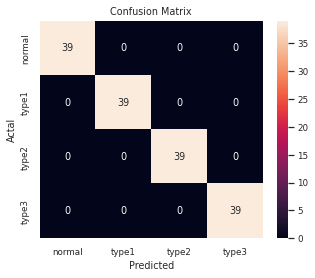

In [ ]:
y_pred = tuned_svm.predict(combined_test[:,:-1])

accuracy = accuracy_score(combined_test[:,-1], y_pred)
f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
print('Accuracy: ', "%.2f" % (accuracy*100))
print('F1: ', "%.2f" % (f1*100))

# Confusion Matrix 생성
Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

cm_df = pd.DataFrame(Confusion_Matrix,
                     index = ['normal','type1','type2','type3'], 
                     columns = ['normal','type1','type2','type3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal')
plt.xlabel('Predicted')
plt.show()

#### 5-2. 랜덤 포레스트 (Random Forest) 모델 성능 평가

Accuracy:  100.00
F1:  100.00


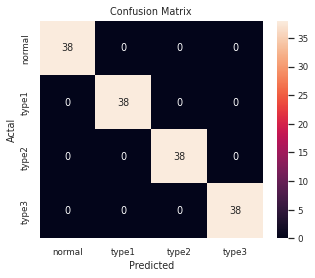

In [ ]:
y_pred = tuned_rf.predict(combined_test[:,:-1])

accuracy = accuracy_score(combined_test[:,-1], y_pred)
f1 = f1_score(combined_test[:,-1], y_pred, average='weighted')
print('Accuracy: ', "%.2f" % (accuracy*100))
print('F1: ', "%.2f" % (f1*100))

# Confusion Matrix 생성
Confusion_Matrix = confusion_matrix(combined_test[:,-1], y_pred)

cm_df = pd.DataFrame(Confusion_Matrix,
                     index = ['normal','type1','type2','type3'], 
                     columns = ['normal','type1','type2','type3'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal')
plt.xlabel('Predicted')
plt.show()

#### DL모델 평가

In [ ]:
def test_model(model, PATH):
    model = torch.load(PATH + 'model.pt')
    #---------------------- 모델 시험 ---------------------#
    model.eval()
    total = 0.0
    accuracy = 0.0
    for batch_idx, data in enumerate(test_dataloader):
        x_test, y_test = data
            
        t_hat = model(x_test)
        _, predicted = torch.max(t_hat.data, 1)
        total += y_test.size(0)
        accuracy += (predicted == y_test).sum().item()
    accuracy = (accuracy / total)
    #------------------------------------------------------#
    print(accuracy)

#### 혼동 행렬 (Confusion matrix)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def draw_confusion_matrix(model, xt, yt, PATH):
    y_pred = []; y_true = []
    
    model.eval()
    y_hat = model(xt)
    output = (torch.max(torch.exp(y_hat), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    
    labels = y_test.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
    
    # 분류 항목
    classes = ('Normal', 'Type1', 'Type2', 'Type3')
    
    # Confussion Matrix 생성
    plt.figure(figsize = (7,5))
    dlen = float(len(x_test)) # test data 크기 : 여기서는 80000
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm/dlen, index = [i for i in classes],columns = [i for i in classes])
    
    # annot : 각 셀의 데이터 값을 나타내는 옵션
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", size=24, fontweight='bold')
    plt.xlabel("Predicted Label", size=16); plt.ylabel("Actual Label", size=16)
    # 각 축의 font 조정
    plt.rc('xtick', labelsize=12); plt.rc('ytick', labelsize=12); plt.yticks(rotation=0)
    # 결과 저장
    plt.savefig(PATH + 'cm_output.png')

#### 손실(Loss) 그래프

In [ ]:
def plot_loss_graph(loss_values, loss_values_v):
    plt.figure()
    plt.plot(loss_values)
    plt.plot(loss_values_v)
    plt.title("Training & Validation Loss")
    plt.ylabel("loss", fontsize="large")
    plt.xlabel("epoch", fontsize="large")
    plt.legend(["train", "validation"])
    plt.tight_layout()
    # 결과 저장
    plt.savefig(PATH + 'lossplot_output.png')

### 5-3. 심층신경망 (DNN) 모델 성능 평가
#### (1) 모델 평가

In [ ]:
PATH = '/content/DNN_'
test_model(DNN_model, PATH)

0.6291625


#### (2) 혼동 행렬 (Confusion matrix)

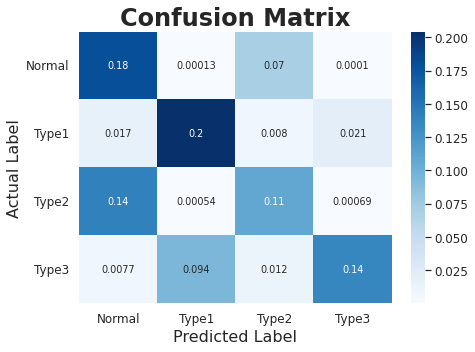

In [ ]:
draw_confusion_matrix(DNN_model, x_test, y_test, PATH)

#### (3) 손실(Loss) 그래프

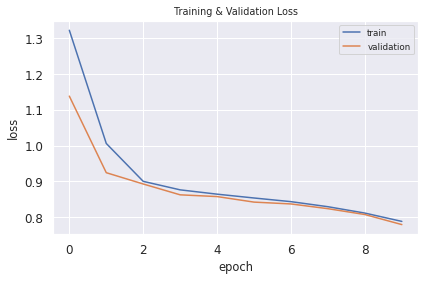

In [ ]:
plot_loss_graph(DNN_loss_values, DNN_loss_values_v)

### 5-4. 합성곱신경망 (CNN) 모델  성능 평가

#### (1) 모델 평가

In [ ]:
PATH = '/content/CNN_'
test_model(CNN_model, PATH)

0.5242875


#### (2) 혼동 행렬 (Confusion matrix)

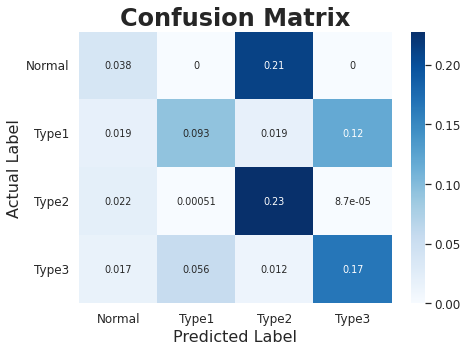

In [ ]:
draw_confusion_matrix(CNN_model, x_test, y_test, PATH)

#### (3) 손실(Loss) 그래프

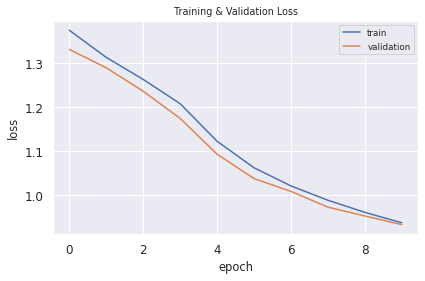

In [ ]:
plot_loss_graph(CNN_loss_values, CNN_loss_values_v)

### 5-5. 순환신경망 (RNN) 모델  성능 평가

#### (1) 모델 평가

In [ ]:
PATH = '/content/RNN_'
test_model(RNN_model, PATH)

0.445525


#### (2) 혼동 행렬 (Confusion matrix)

In [ ]:
draw_confusion_matrix(RNN_model, x_test, y_test, PATH)

#### (3) 손실(Loss) 그래프

In [ ]:
plot_loss_graph(RNN_loss_values, RNN_loss_values_v)